## Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 22.09.2018

Мягкий дедлайн: 7:59MSK 02.10.2018

Жесткий дедлайн: 23:59MSK 03.10.2018

### О задании

Задание состоит из двух частей: в **первой** части вы научитесь применять готовые модели из `sklearn` на данных и исследуете особенности разных видов регуляризации; во **второй** части вы реализуете собственный класс линейной регрессии для нестандартной функции потерь (включая процесс обучения) и исследуете скорость сходимости различных градиентных методов для этой модели.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Присылать необходимо ноутбук с выполненным заданием. Часть задания сдаётся в Яндекс.Контест. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

In [1]:
! wget -nc https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2018-fall/homeworks-practice/data/homework-practice-03-data.csv -P ./data/ 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('./data/homework-practice-03-data.csv')

## Линейная регрессия из коробки

#### 1. [0.5 балла] Разбейте выборку, загруженную в ячейке выше в переменную `df`, на обучающую и тестовую части в соотношении 8:2.

In [4]:
df[:5]

,f0,f1,f2,f3,f4,f5,f6
0,16.99,1.01,0.976270,-3.697815,0.623295,0.524760,7199.992000
1,10.34,1.66,4.303787,7.715073,0.886961,0.473862,2466.136700
2,21.01,3.50,2.055268,-6.464284,0.618826,1.657394,2969.369100
3,23.68,3.31,0.897664,1.335254,0.133461,1.234554,1040.665300
4,24.59,3.61,-1.526904,-0.196414,0.980580,3.086397,37.469975


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

#### 2. [0.5 балла] В качестве целевой переменной для задачи регрессии будем использовать значения признака f1. Обучите, а затем провалидируйте на тестовых данных  следующие модели, используя в качестве метрики качества $R^2$:
* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) (линейная регрессия с $L1$-регуляризатором) с коэффициентом регуляризации, равным 0.01.

Не забудьте отмасштабировать данные перед обучением моделей!

In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
x_train, x_test = map(lambda x: x.drop(columns=['f1']), [df_train, df_test])
y_train, y_test = map(lambda x: x['f1'], [df_train, df_test])

In [9]:
linear_regr = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', LinearRegression())])
lasso_regr = Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Lasso(alpha=0.01))])

In [10]:
models = [lasso_regr, linear_regr]
for model in models:
    model.fit(x_train, y_train)
    print(type(model.named_steps['regressor']).__name__, model.score(x_test, y_test))

Lasso 0.4915262231927189
LinearRegression 0.47994089876103696


#### 3. [1 балл] Изучите значения параметров получившихся моделей и сравните количество строго нулевых весов в них.

In [11]:
for model in models:
    regr = model.named_steps['regressor']
    print(type(regr).__name__, regr.coef_, 'With %d null coefficients' % (regr.coef_ == 0).sum(),
          'Null features: ' + ', '.join(x_train.columns.values[np.where(regr.coef_ == 0)]) , sep='\n\t')

Lasso
	[ 0.91654943 -0.01475931 -0.04294885  0.02392738  0.16376442  0.        ]
	With 1 null coefficients
	Null features: f6
LinearRegression
	[ 0.92547018 -0.02421687 -0.0533652   0.0317247   0.1739215   0.00195512]
	With 0 null coefficients
	Null features: 


Как видим веса у признаков получились примерно одинаковыми, но у модели с $L_1$ регуляризацией есть нулевой коэффициент

#### 4. [1 балл] Нарисуйте попарные scatter plot для всех признаков в исходных данных (включая f1). Можно ли что-то сказать о связи признаков, веса которых были занулены методом Lasso, с целевой переменной?

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

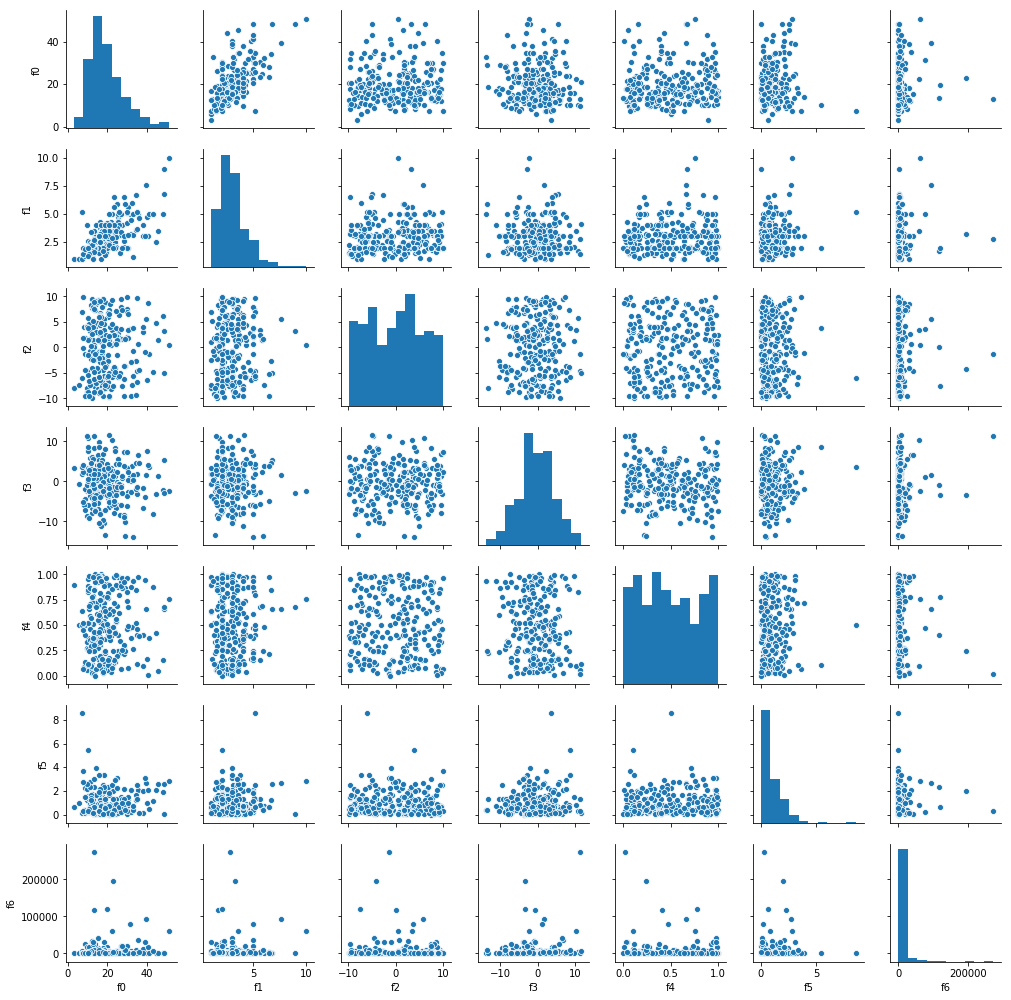

In [13]:
sns.pairplot(df, height=2)

Смотрим f1 vs f3. Видим, что зависимость совсем не похожа на линейную. Так можно сказать про все признаки, вес которых близок к 0

## Реализация градиентного спуска

#### 5. [4 балла] Реализуйте модель линейной регрессии для функции потерь Huber loss, обучаемую градиентным спуском:

$$
L_\delta(a,y)=
\begin{cases}
 \frac{1}{2}(y - a)^2,                   & |y - a| \le \delta, \\
 \delta\, |y - a| - \frac{1}{2}\delta^2 & \textrm{иначе.}
\end{cases}
$$

Все вычисления должны быть векторизованы, циклы средствами python допускается использовать только для итераций градиентного спуска. В качестве критерия останова необходимо использовать (одновременно):

* проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
* достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).

Необходимо реализовать метод полного и стохастического градиентных спусков, а также поддержать метод momentum при помощи параметра `alpha` (способ оценивания градиента должен задаваться при помощи параметра `gd_type`).

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту).

Инициализировать веса можно случайным образом или нулевым вектором. Ниже приведён шаблон класса, который должен содержать код реализации модели.

__Python-файл с реализованным классом необходимо сдать на проверку в [Яндекс.Контест](https://contest.yandex.ru/contest/9247/)__

Укажите ссылку на посылку (run-report):

$$
L_\delta(a, y)'_a = 
\begin{cases}
    -(y-a),\quad\text{если }|y-a|\leq \delta,\\
    -sgn(y-a)\cdot\delta,\quad\text{иначе} 
\end{cases}
$$

Теперь найдем градиент по весам
$$
L_\delta(a, y)'_\omega = L_\delta(a, y)'_a \cdot a'_\omega = L_\delta(a, y)'_a \cdot x 
$$
Итого:
$$
L_\delta(a, y)'_\omega = 
\begin{cases}
    -x\cdot (y-<x,\omega>),\quad\text{если }|y-<x, \omega>|\leq \delta,\\
    -x \cdot sgn(y-<x,\omega>)\cdot\delta,\quad\text{иначе} 
\end{cases}
$$

Запишем минимизируемый функционал:
$$
Q(X, \omega) = \dfrac{1}{n}\sum_{i=1}^l L_\delta(<x_i, \omega>, y_i) \to min
$$

In [14]:
from sklearn.base import BaseEstimator
import numpy as np

class HuberReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, alpha=1e-3, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        if (len(X.shape) == 1):
            X = X.reshape((-1, 1))
        self.loss_history = []
        self.w = np.zeros(X.shape[1], dtype=np.float)
        if self.w0 != None:
            self.w = self.w0
        iteration = 0
        self.loss_history.append(self.calc_loss(X, y))
        last_w = None
        inertion = np.zeros_like(self.w)
        while iteration < self.max_iter and (iteration == 0 or np.linalg.norm(self.w - last_w) >= self.tolerance):
            batch_size = 0
            if self.gd_type == 'stochastic':
                batch_size = 1
            elif self.gd_type == 'full':
                batch_size = X.shape[0]
            else:
                raise Exception('bad gd_type')
            batch, target = self.__get_batch(X, y, batch_size)
            grad = self.calc_gradient(batch, target)
            inertion = self.alpha * inertion + self.eta * grad
            last_w = self.w.copy()
            self.w -= inertion
            self.loss_history.append(self.calc_loss(X, y))
            iteration += 1
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        dy_minus = (X.dot(self.w) - y)
        compare_result = np.absolute(dy_minus) <= self.delta
        grad = np.zeros_like(X.shape[1])
        true_ind = np.where(compare_result == True)
        false_ind = np.where(compare_result == False)
        grads_true = np.zeros(self.w.shape[0])
        grads_false = np.zeros(self.w.shape[0])
        if true_ind[0].shape[0] != 0:            
            grads_true = (dy_minus[true_ind].dot(X[true_ind[0], :]))
        if false_ind[0].shape[0] != 0:
            grads_false = (np.sign(dy_minus[false_ind]).dot(X[false_ind[0], :])) * self.delta
        return ((grads_true + grads_false) / X.shape[0]).flatten()

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        dy_abs = np.absolute(y - X.dot(self.w))
        compare_result = dy_abs <= self.delta
        true_sum = (dy_abs[np.where(compare_result == True)]**2 / 2).sum()
        false_sum = ((dy_abs[np.where(compare_result == False)] - self.delta / 2) * self.delta).sum()
        return (true_sum + false_sum) / y.shape[0]
    
    def __get_batch(self, X, y, size=1):
        ind = np.random.choice(np.arange(X.shape[0]), size=size)
        return X[ind, :].reshape((size, -1)), y[ind]

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
sgd = HuberReg(eta=0.001, tolerance=1e-10, max_iter=10)
sgd.fit(x_train.values, y_train.values)
sgd.w

array([ 0.14107096, -0.00598972,  0.01395125,  0.00389141,  0.01470332,
       -0.33986197])

In [16]:
x = np.linspace(-5, 5, 10000)
y = 4 * x + np.random.normal(scale=1, size=len(x))

In [17]:
import matplotlib.pylab as plt
import seaborn as sns

In [18]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
sgd = HuberReg(max_iter=10000, gd_type='full', alpha=0.3)
sgd.fit(x_train_, y_train_)
sgd.w

array([3.98759855])

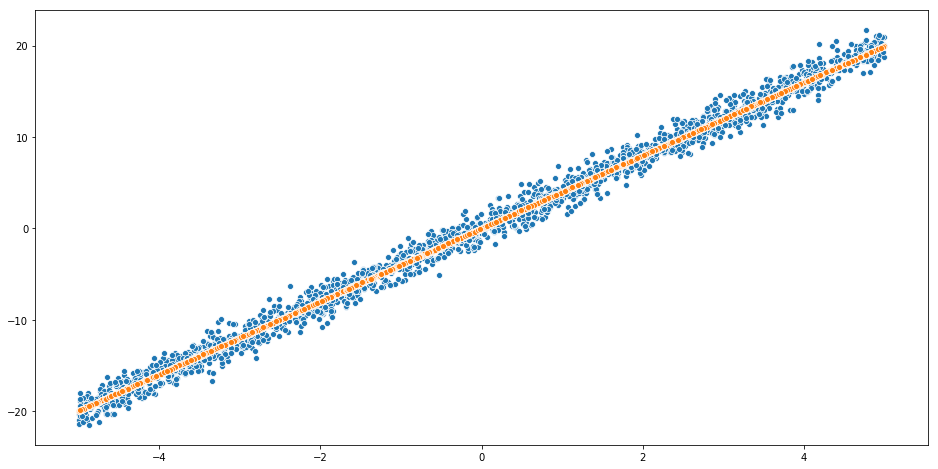

In [20]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x_test_, y_test_)
sns.scatterplot(x_test_, sgd.predict(x_test_))

#### 6. [1.5 балла] Обучите и провалидируйте модель на тех же данных, сравните качество с предыдущими методами. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [21]:
# your code here

#### 7. [1.5 балла] Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом инерции. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны из себя представлять *красивые* графики!

In [22]:
# your code here